
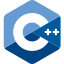
<br>

<div style="text-align:center; font-size:200%;">
  <b>GoF: Command Pattern</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Academy Munich</div>
<br/>
<!-- 09 GoF Command Pattern.ipynb -->
<!-- slides/module_450_design_patterns/topic_230_command.cpp -->


### Intent

- Encapsulate a request as an object, thereby letting you parameterize clients
  with different requests, queue or log requests, and support undoable
  operations.


### Also Known As

Action, Transaction


### Motivation

Commands in graphical user interfaces

- Can be invoked in many different ways (menu, keyboard, mouse)
- Should support undo/redo
- Should be logged
- Should be queued
- Should support macro recording


Possible solution: Implement as object

- Each command is implemented as an object
- The command object encapsulates the operation and its parameters
- The command object provides a method `Execute()` that performs the operation


<img src="img/command_example.svg"
     style="display:block;margin:auto;width:70%"/>

In [ ]:
#include <iostream>
#include <string>

In [ ]:
class Document
{
public:
    Document(std::string text) : text_{std::move(text)} {}

    void Modify(const std::string& new_text)
    {
        std::cout << "  Document::Modify(\"" << new_text << "\")\n";
        text_ = new_text + text_;
    }
    void Append(const std::string& text)
    {
        std::cout << "  Document::Append(\"" << text << "\")\n";
        text_ += text;
    }

    std::string GetState() const { return text_; }
    void Restore(const std::string& state)
    {
        std::cout << "  Document::Restore(\"" << state << "\")\n";
        text_ = state;
    }

private:
    std::string text_;
}

In [ ]:
namespace std
{
    ostream& operator<<(ostream& os, ::Document doc)
    {
        os << doc.GetState();
        return os;
    }
}

In [ ]:
class Command
{
public:
    virtual ~Command() = default;

    virtual void Execute() = 0;
    virtual void Undo() = 0;
};

In [ ]:
int commandCounter{0};

In [ ]:
class ModifyCommand : public Command
{
public:
    ModifyCommand(Document& doc, std::string change)
        : doc_{&doc}, change_{std::move(change)}
    {}

    void Execute() override
    {
        std::cout << "ModifyCommand::Execute()\n";
        state_ = doc_->GetState();
        doc_->Modify("!" + change_ + "_" + std::to_string(counter_));
    }

    void Undo() override
    {
        std::cout << "ModifyCommand::Undo()\n";
        doc_->Restore(state_);
    }

private:
    Document* doc_;
    std::string change_;
    int counter_{++commandCounter};
    std::string state_;
};

In [ ]:
class AppendCommand : public Command
{
public:
    AppendCommand(Document& doc, std::string change)
        : doc_{&doc}, change_{std::move(change)}
    {}

    void Execute() override
    {
        std::cout << "AppendCommand::Execute()\n";
        state_ = doc_->GetState();
        doc_->Append(change_ + "_" + std::to_string(counter_) + "!");
    }

    void Undo() override
    {
        std::cout << "AppendCommand::Undo()\n";
        doc_->Restore(state_);
    }

private:
    Document* doc_;
    std::string change_;
    int counter_{++commandCounter};
    std::string state_;
};

In [ ]:
std::vector<std::unique_ptr<Command>> history;

In [ ]:
class Menu
{
public:
    Menu(Document& doc) : doc_{&doc} {}

    void ModifyDocument()
    {
        auto command{std::make_unique<ModifyCommand>(*doc_, "menu_mod")};
        command->Execute();
        history.push_back(std::move(command));
    }
    void AppendDocument()
    {
        auto command{std::make_unique<AppendCommand>(*doc_, "menu_app")};
        command->Execute();
        history.push_back(std::move(command));
    }
    void Undo()
    {
        if (history.empty())
        {
            return;
        }
        auto& last{history.back()};
        last->Undo();
        history.pop_back();
    }

private:
    Document* doc_;
};

In [ ]:
class KeyboardShortcuts
{
public:
    KeyboardShortcuts(Document& doc) : doc_{&doc} {}

    void ModifyDocument()
    {
        auto save = std::make_unique<ModifyCommand>(*doc_, "key_mod");
        save->Execute();
        history.push_back(std::move(save));
    }
    void AppendDocument()
    {
        auto save = std::make_unique<AppendCommand>(*doc_, "key_app");
        save->Execute();
        history.push_back(std::move(save));
    }
    void Undo()
    {
        if (history.empty())
        {
            return;
        }
        auto& last{history.back()};
        last->Undo();
        history.pop_back();
    }

private:
    Document* doc_;
}

In [ ]:
commandCounter = 0;
Document doc{"<<doc>>"};
Menu menu{doc};
KeyboardShortcuts shortcuts{doc};
std::cout << "  " << doc << '\n';

In [ ]:
menu.ModifyDocument();
std::cout << "  " << doc << '\n';

In [ ]:
shortcuts.ModifyDocument();
std::cout << "  " << doc << '\n';

In [ ]:
menu.AppendDocument();
std::cout << "  " << doc << '\n';

In [ ]:
std::cout << "  " << doc << '\n';
shortcuts.ModifyDocument();
std::cout << "  " << doc << '\n';

In [ ]:
shortcuts.AppendDocument();
std::cout << "  " << doc << '\n';

In [ ]:
menu.Undo();
std::cout << "  " << doc << '\n';

In [ ]:
menu.Undo();
std::cout << "  " << doc << '\n';

In [ ]:
shortcuts.Undo();
std::cout << "  " << doc << '\n';

In [ ]:
std::cout << "  " << doc << '\n';
shortcuts.ModifyDocument();
std::cout << "  " << doc << '\n';

In [ ]:
shortcuts.AppendDocument();
std::cout << "  " << doc << '\n';

In [ ]:
menu.Undo();
std::cout << "  " << doc << '\n';

In [ ]:
shortcuts.Undo();
std::cout << "  " << doc << '\n';


### Applicability

- Parameterize objects by an action to perform
- Specify and execute operations at different times
- Queues of operations
- Support undoable operations
- Support logging changes so that they can be reapplied in case of a system
  crash
- Support transactions


### Structure

<img src="img/pat_command.svg"
     style="display:block;margin:auto;width:70%"/>


### Participants

- **Command**
  - Declares an interface for executing an operation
- **ConcreteCommand**
  - Defines a binding between a `Receiver` object and an action
  - Implements `Execute()` by invoking the corresponding operation(s) on
    `Receiver`
- **Client**
  - Creates a `ConcreteCommand` object and sets its `Receiver`
- **Invoker**
  - Calls `Execute()` on `ConcreteCommand` to carry out the request


### Sequence Diagram

<img src="img/pat_command_seq.svg"
     style="display:block;margin:auto;width:70%"/>


### Collaborations

- A client creates a `ConcreteCommand` object and specifies its receiver.
- An invoker stores the `ConcreteCommand` object.
- The invoker issues a request by calling `Execute()` on the command. When
  commands are undoable, `ConcreteCommand` stores state for reversing its
  effects in the command itself.
- The `ConcreteCommand` object invokes operations on its receiver to carry
  out the request.


### Consequences

- Easy to add new `ConcreteCommand` classes
- Easy to implement undo and redo
- Decouples `Client`, `Invoker`, and `Receiver`
- Supports `MacroCommands`


### Implementation

- For simple scenarios, a `SimpleCommand` class that stores a pointer to a
  member function can be used
- ...

In [ ]:
class SimpleCommand : public Command
{
public:
    using Action = void (Document::*)(const std::string& new_text);

    SimpleCommand(Document& doc, Action action, std::string text)
        : doc_{&doc}, action_{action}, text_{text}
    {}

    void Execute() override
    {
        std::cout << "SimpleCommand::Execute()\n";
        state_ = doc_->GetState();
        (doc_->*action_)("!" + text_ + "_" + std::to_string(counter_) + "!");
    }

    void Undo() override
    {
        std::cout << "SimpleCommand::Undo()\n";
        doc_->Restore(state_);
    }

private:
    Document* doc_;
    Action action_;
    std::string text_;
    int counter_{++commandCounter};
    std::string state_;
};

In [ ]:
void RunSimpleAction(
    Document& doc, SimpleCommand::Action action, const std::string& text
)
{
    auto command{std::make_unique<SimpleCommand>(doc, action, text)};
    command->Execute();
    history.push_back(std::move(command));
}

In [ ]:
void Undo()
{
    if (history.empty())
    {
        return;
    }
    auto& last{history.back()};
    last->Undo();
    history.pop_back();
}

In [ ]:
history.clear();
commandCounter = 0;
Document doc{"<<doc>>"};
std::cout << "  " << doc << '\n';

In [ ]:
RunSimpleAction(doc, &Document::Modify, "mod");
std::cout << "  " << doc << '\n';

In [ ]:
RunSimpleAction(doc, &Document::Append, "app");
std::cout << "  " << doc << '\n';

In [ ]:
RunSimpleAction(doc, &Document::Modify, "mod");
std::cout << "  " << doc << '\n';

In [ ]:
Undo();
std::cout << "  " << doc << '\n';

In [ ]:
Undo();
std::cout << "  " << doc << '\n';

In [ ]:
RunSimpleAction(doc, &Document::Append, "app");
std::cout << "  " << doc << '\n';

In [ ]:
Undo();
std::cout << "  " << doc << '\n';

In [ ]:
Undo();
std::cout << "  " << doc << '\n';

In [ ]:
Undo();
std::cout << "  " << doc << '\n';


## Workshop: Command Pattern

### Scenario

A bank wants to improve its online banking system. The system should offer various
functions such as making transfers, setting up standing orders, and checking account
balances. Additionally, it should be possible to undo the last action in case a
customer has made a mistake.


### Objective

Your task is to implement the online banking operations using the Command Pattern.
This should allow for easy expansion of the system in the future and provide an undo
function for the last transaction.


### Starter Code

In [ ]:
#include <iostream>
#include <string>
#include <vector>

In [ ]:
struct StandingOrder
{
    StandingOrder(double amount, std::string recipient, std::string frequency)
        : amount{amount},
          recipient{std::move(recipient)},
          frequency{std::move(frequency)}
    {}
    double amount;
    std::string recipient;
    std::string frequency;
};

In [ ]:
class Account
{
private:
    std::string account_number_;
    double balance_;
    std::vector<StandingOrder> standing_orders_;

public:
    Account(const std::string& account_number, double initial_balance)
        : account_number_(account_number), balance_(initial_balance)
    {}

    void Transfer(double amount, const std::string& recipient)
    {
        if (amount <= balance_)
        {
            balance_ -= amount;
            std::cout << "Transferred: $" << amount << " to " << recipient
                      << ". New Balance: $" << balance_ << "\n";
        }
        else
        {
            std::cout << "Insufficient funds. Current Balance: $" << balance_ << "\n";
        }
    }

    void SetupStandingOrder(
        double amount, const std::string& recipient, const std::string& frequency
    )
    {
        std::cout << "Set up standing order: $" << amount << " to " << recipient << " "
                  << frequency << "\n";
        standing_orders_.emplace_back(amount, recipient, frequency);
    }

    void CancelStandingOrder(const std::string& recipient)
    {
        auto it = std::find_if(
            standing_orders_.begin(), standing_orders_.end(),
            [&recipient](const StandingOrder& so) { return so.recipient == recipient; }
        );
        if (it != standing_orders_.end())
        {
            std::cout << "Cancelled standing order: $" << it->amount << " to "
                      << it->recipient << " " << it->frequency << "\n";
            standing_orders_.erase(it);
        }
        else
        {
            std::cout << "No standing order found for recipient: " << recipient << "\n";
        }
    }

    double GetBalance() const { return balance_; }
    std::string GetAccountNumber() const { return account_number_; }
    const std::vector<StandingOrder>& GetStandingOrders() const
    {
        return standing_orders_;
    }
};

In [ ]:
namespace std
{
ostream& operator<<(ostream& os, const ::Account& acc)
{
    os << "Account: " << acc.GetAccountNumber() << ", Balance: $" << acc.GetBalance();

    if (acc.GetStandingOrders().empty())
    {
        os << ", No Standing Orders\n";
    }
    else
    {
        os << "\n  Standing Orders:";
        for (const auto& so : acc.GetStandingOrders())
        {
            os << "\n    Amount: $" << so.amount << ", Recipient: " << so.recipient
               << ", Frequency: " << so.frequency;
        }
        os << "\n";
    }
    return os;
}
} // namespace std

In [ ]:
class OnlineBankingSystem
{
private:
    Account account_;

public:
    OnlineBankingSystem(const std::string& account_number, double initial_balance)
        : account_(account_number, initial_balance)
    {}

    const Account& GetAccount() const { return account_; }

    // TODO: Implement Transfer, SetupStandingOrder, and Undo operations using the
    // Command pattern.
};